In [ ]:
# References:
# https://github.com/milesial/Pytorch-UNet/tree/67bf11b4db4c5f2891bd7e8e7f58bcde8ee2d2db

In [ ]:
!pip install torch torchvision

### UNET Segmentation (One Image)

In [47]:
import torch
from torchvision import transforms, datasets
from torch import nn, optim
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [48]:
# PARAMETERS
img_url = "https://raw.githubusercontent.com/yungewww/AIGC-LLM-ToolBox/refs/heads/main/dataset/cat.jpg"
label_url = "https://raw.githubusercontent.com/yungewww/AIGC-LLM-ToolBox/refs/heads/main/dataset/cat_label.jpg"
img_size = 256

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


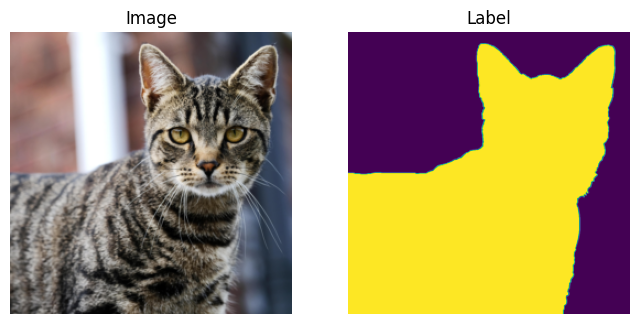

In [49]:
# PREPROCESS IMAGE

def preprocess_image(url, img_size, type = 'image'):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    if type == 'label':
      img = img.convert('L')

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    tensor = transform(img).unsqueeze(0)

    return tensor

def show_tensor_images(tensors, names=None):
    num_imgs = len(tensors)
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs * 4, 4))

    if num_imgs == 1:
        axs = [axs]

    for i, tensor in enumerate(tensors):
        img = transforms.ToPILImage()(tensor.squeeze(0))
        axs[i].imshow(img)
        if names is not None and len(names) > i:
            axs[i].set_title(names[i])
        else:
            axs[i].set_title(f'Image {i+1}')
        axs[i].axis('off')  # 关闭坐标轴

    plt.show()

# tensor shape should be (1, C, H, W)
image_tensor = preprocess_image(img_url, img_size)
label_tensor = preprocess_image(label_url, img_size, 'label')
print(image_tensor.shape)
print(label_tensor.shape)

show_tensor_images([image_tensor, label_tensor], ['Image', 'Label'])

In [50]:
# MODEL
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Contracting path
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = CBR(512, 1024)

        # Expanding path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoding
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.final(dec1))

model = UNet().to('cuda')

torch.Size([1, 1, 256, 256])


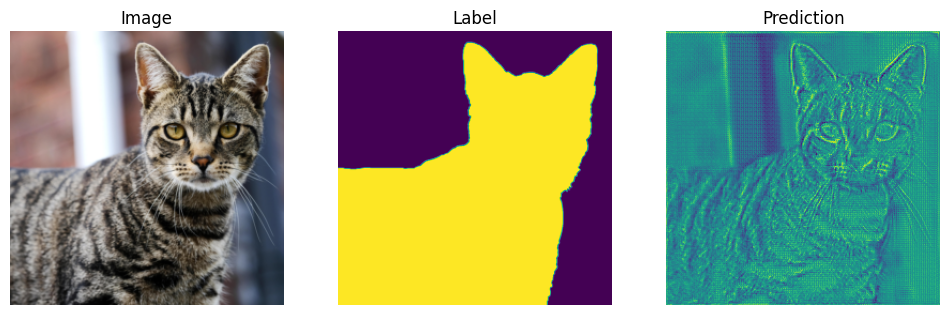

In [51]:
# IF NOT TRAINED
pred = model(image_tensor.to('cuda'))
print(pred.shape)
show_tensor_images([image_tensor, label_tensor, pred], ['Image', 'Label', 'Prediction'])

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

image_tensor = image_tensor.to('cuda')
label_tensor = label_tensor.to('cuda')

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model_single_image(model, image, label, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Forward
        outputs = model(image)
        loss = criterion(outputs, label)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}")


train_model_single_image(model, image_tensor, label_tensor, criterion, optimizer, num_epochs=30)

Epoch [1/30], Loss: 0.06304957717657089
Epoch [2/30], Loss: 0.3590179979801178
Epoch [3/30], Loss: 0.08284027874469757
Epoch [4/30], Loss: 0.10398288816213608
Epoch [5/30], Loss: 0.11442358046770096
Epoch [6/30], Loss: 0.10799015313386917
Epoch [7/30], Loss: 0.0978870615363121
Epoch [8/30], Loss: 0.08402553200721741
Epoch [9/30], Loss: 0.07333896309137344
Epoch [10/30], Loss: 0.06652514636516571
Epoch [11/30], Loss: 0.06175214797258377
Epoch [12/30], Loss: 0.05805061757564545
Epoch [13/30], Loss: 0.05522423982620239
Epoch [14/30], Loss: 0.05317777767777443
Epoch [15/30], Loss: 0.05126773193478584
Epoch [16/30], Loss: 0.04913608729839325
Epoch [17/30], Loss: 0.04707798361778259
Epoch [18/30], Loss: 0.04527965560555458
Epoch [19/30], Loss: 0.04374125599861145
Epoch [20/30], Loss: 0.04223060607910156
Epoch [21/30], Loss: 0.040699928998947144
Epoch [22/30], Loss: 0.039376381784677505
Epoch [23/30], Loss: 0.03826058655977249
Epoch [24/30], Loss: 0.03696093335747719
Epoch [25/30], Loss: 0.03

torch.Size([1, 1, 256, 256])


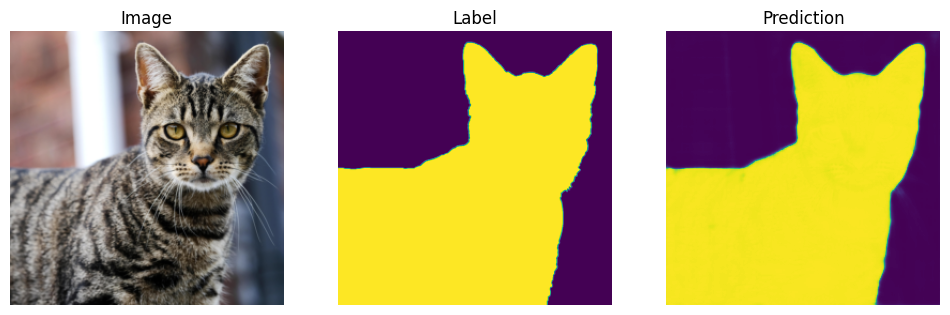

In [61]:
# PREDICTION
pred = model(image_tensor.to('cuda'))
print(pred.shape)
show_tensor_images([image_tensor, label_tensor, pred], ['Image', 'Label', 'Prediction'])